# 프로젝트: Face2Emoji 모바일 웹앱

## Step 1 표정 데이터로 MobileNet 학습하기

In [1]:
import numpy as np
import tqdm
import os

import tensorflow as tf

얼굴 흑백 픽셀값 pixels 컬럼을 X 항목으로, 감정 번호 emotion 컬럼을 y 항목으로 삼으려고 합니다. X항목은 48x48 pixel의 grayscale images(채널 1개)로 알려져 있습니다. 그리고 grayscale은 0~255의 정수로 표현되어 있습니다. 우리는 X 항목을 (48, 48, 1)로 reshape하고, 255로 나누어 정규화하려고 합니다.

In [2]:

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
  for line in tqdm.tqdm(f.read().splitlines()[1:]):
    emotion, pixels, usage = line.split(',')
    
    x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
    y = int(emotion)

    if usage == 'PrivateTest':
      eval_x.append(x)
      eval_y.append(y)
    else:
      train_x.append(x)
      train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:28<00:00, 1251.08it/s]train : 32298, eval :3589



In [3]:
# 48x48x1 행렬이 32298 개 있는거.
len(train_x)

32298

Angry


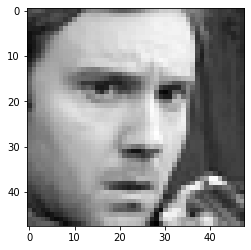

In [4]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

### MobileNet 모델 학습하기

In [5]:
# tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4406299453463833585
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12746455998474311230
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11135101403780631053
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7016061344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11601108222511753443
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Default GPU Device: /device:GPU:0


In [8]:
# tf.debugging.set_log_device_placement(True)


model = tf.keras.applications.MobileNetV2(
    input_shape=(48,48,1),
    weights=None,
    classes=7
)

model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(np.stack(train_x),
        tf.keras.utils.to_categorical(train_y),
        epochs=100,
        # epochs=5,
        batch_size=512,
        validation_data=(np.stack(eval_x),
                        tf.keras.utils.to_categorical(eval_y)))

Epoch 1/100
64/64 [==============================] - 54s 842ms/step - loss: 1.8243 - categorical_accuracy: 0.2454 - val_loss: 1.9281 - val_categorical_accuracy: 0.2449
Epoch 2/100
64/64 [==============================] - 7s 105ms/step - loss: 1.6778 - categorical_accuracy: 0.3306 - val_loss: 1.9233 - val_categorical_accuracy: 0.1655
Epoch 3/100
64/64 [==============================] - 7s 106ms/step - loss: 1.5766 - categorical_accuracy: 0.3881 - val_loss: 1.9258 - val_categorical_accuracy: 0.1655
Epoch 4/100
64/64 [==============================] - 7s 106ms/step - loss: 1.4799 - categorical_accuracy: 0.4294 - val_loss: 1.9312 - val_categorical_accuracy: 0.1655
Epoch 5/100
64/64 [==============================] - 7s 106ms/step - loss: 1.4002 - categorical_accuracy: 0.4648 - val_loss: 1.9410 - val_categorical_accuracy: 0.1655
Epoch 6/100
64/64 [==============================] - 7s 106ms/step - loss: 1.3281 - categorical_accuracy: 0.4959 - val_loss: 1.9440 - val_categorical_accuracy: 0.16

## Step 2 학습된 모델을 Tensorflow.js 형식으로 변환하기

학습 완료시, 케라스의 경우 모델을 HDF5(.h5) 형식으로 저장.
또는 Tensorflow.js converter에서 지원하는 다른 형식으로 저장해도 무관. 

In [12]:
model_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/model.h5'
model.save(model_path)


NameError: name 'model' is not defined

In [ ]:
loaded_model = tf.keras.models.load_model(model_path)


그리고 저장한 모델을 tensorflow.js 로 변환
터미널에서 tensorflowjs_converter 명령어 실행.

 - cd ~/aiffel/tfjs_mobile   
 - tensorflowjs_converter --input_format=keras model.h5 model
 

## Step 3 카메라에서 가져온 영상 전처리하기

## Step 4 MobileNet 추론 결과 표시하기

## Step 5 github page 에 배포

https://bluecandle.github.io/tfjs_mobile_practice/

오류나서 오류 내용 살펴보니... 모델 load 가 안됨!